<h2><font color='#306998'><center>451 Financial Engineering: Programming Assignment 1</center></font></h2>
<h3><center>Thomas W. Miller, June 18, 2025</center></h3>
---

## Overview 
We use machine learing classifiers, including tree-based ensemble boosting methods, to predict the direction of oil futures (up or down) using a number of lagged price features. In particular, we look at daily closing spot prices for [West Texas Intermediate (ticker btc)](https://en.wikipedia.org/wiki/West_Texas_Intermediate) with lags of one to seven days, as well as features based on opening, closing, high, and low price points, and daily trading volume.

A model for predicting the direction of daily returns sets the stage for testing the predictive utility of additional features. The domain of potential features or leading indicators is wide, including those associated with other price series, economic indicators, international events, securities filings, analyst and news reports, and media measures.

### Import Libraries
We draw on Python packages for data manipulation and modeling. Most important are Polars, a high-performance alternative to Pandas for data manipulation, and Scikit-Learn for machine learning study design and modeling algorithms.

In [3]:
import os
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)

# Import Python Packages for data manipulation, data pipelines, and databases
import numpy as np
import pyarrow # foundation for polars
import polars as pl # DataFrame work superior to Pandas

# Plotting
import matplotlib.pyplot as plt
# Display static plots directly in the notebook output 
%matplotlib inline
# create stylized visualizations, including heat maps
import seaborn as sns

# Preprocessing
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import (RandomizedSearchCV, 
                                    TimeSeriesSplit)
from sklearn.model_selection import cross_validate

# utilized in all possible subsets classification work
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss

# needed for randomized search
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

# metrics in xgboost tuning and final model evaluation
from sklearn.metrics import (accuracy_score,
                             classification_report, 
                             roc_curve, 
                             roc_auc_score,
                             RocCurveDisplay,
                             ConfusionMatrixDisplay,
                             confusion_matrix,
                             precision_score,
                             recall_score,
                             f1_score
                            )

# XGBoost Package... more complete than SciKit-Learn boosting methods
import xgboost as xgb
from xgboost import XGBRegressor, XGBClassifier, plot_importance

# import yfinance as yf  # used earlier to obtain the price series
# import yfinance as yf

import warnings
# Suppress warnings for cleaner output
warnings.filterwarnings('ignore') 

### Retrieve Data
In previous work, we retrieved price data for btc from Yahoo Finance. The code is shown in the next commented-out cell.

In [ ]:
'''
Previous work to retrieve data from Yahoo Finance

symbol = 'btc'
start_date = '2000-01-01'
end_date = '2025-05-27'

symbol = 'btc'
ticker = yf.Ticker(symbol)
historical_data = ticker.history(start = start_date, end = end_date, period = '1mo')
print(historical_data)

print("type of historical_data", type(historical_data))

historical_data.to_csv("btc_historical_data.csv")
'''

'\nPrevious work to retrieve data from Yahoo Finance\n\nsymbol = \'WTI\'\nstart_date = \'2000-01-01\'\nend_date = \'2025-05-27\'\n\nsymbol = \'WTI\'\nticker = yf.Ticker(symbol)\nhistorical_data = ticker.history(start = start_date, end = end_date, period = \'1mo\')\nprint(historical_data)\n\nprint("type of historical_data", type(historical_data))\n\nhistorical_data.to_csv("wti_historical_data.csv")\n'

### Polars DataFrame Development
The following code cell demonstrates Polars use with the time series DataFrame for our selected market/ticker, btc.

In [ ]:
import pandas as pd
btc = pl.read_parquet("C:\\Users\\Genki\\Documents\\Homework\\Financial Machine Learning\\HW1\\btc_historical_data.parquet")

#btc = pd.read_csv("C:/Users/Genki/Documents/Homework/Financial Machine Learning/HW1/btc_historical_data.csv")
#btc = pl.read_parquet("my_data_frame.parquet")
# check the original schema
print(btc.schema)

# create lag price features
btc = btc.with_columns((pl.col('Close')).shift().alias('CloseLag1'))
btc = btc.with_columns((pl.col('CloseLag1')).shift().alias('CloseLag2'))
btc = btc.with_columns((pl.col('CloseLag2')).shift().alias('CloseLag3'))

# create high-minus-low (HML) for day and its lags
btc = btc.with_columns((pl.col('High') - pl.col('Low')).alias('HML'))
btc = btc.with_columns((pl.col('HML')).shift().alias('HMLLag1'))
btc = btc.with_columns((pl.col('HMLLag1')).shift().alias('HMLLag2'))
btc = btc.with_columns((pl.col('HMLLag2')).shift().alias('HMLLag3'))

# create a net change for the day as the open minus closing price OMC
# also create the corresponding lag metrics
btc = btc.with_columns((pl.col('Open') - pl.col('Close')).alias('OMC'))
btc = btc.with_columns((pl.col('OMC')).shift().alias('OMCLag1'))
btc = btc.with_columns((pl.col('OMCLag1')).shift().alias('OMCLag2'))
btc = btc.with_columns((pl.col('OMCLag2')).shift().alias('OMCLag3'))

# create volume lag metrics
btc = btc.with_columns((pl.col('Volume')).shift().alias('VolumeLag1'))
btc = btc.with_columns((pl.col('VolumeLag1')).shift().alias('VolumeLag2'))
btc = btc.with_columns((pl.col('VolumeLag2')).shift().alias('VolumeLag3'))

# compute 10-day exponential moving averages of closing prices
# compute acround CloseLag1 to avoid any "leakage" in explanatory variable set
# note also the 10-day buffer between train and test in time-series cross-validation
btc = btc.with_columns((pl.col('CloseLag1').ewm_mean(half_life=1,ignore_nulls=True)).alias('CloseEMA2'))
btc = btc.with_columns((pl.col('CloseLag1').ewm_mean(half_life=2,ignore_nulls=True)).alias('CloseEMA4'))
btc = btc.with_columns((pl.col('CloseLag1').ewm_mean(half_life=4,ignore_nulls=True)).alias('CloseEMA8'))

# log daily returns
btc = btc.with_columns(np.log(pl.col('Close')/pl.col('CloseLag1')).alias('LogReturn'))

# set volume features to Float64 for subsequent use in Numpy arrays
btc = btc.with_columns(
    pl.col('Volume').cast(pl.Float64).round(0),
    pl.col('VolumeLag1').cast(pl.Float64).round(0),
    pl.col('VolumeLag2').cast(pl.Float64).round(0),
    pl.col('VolumeLag3').cast(pl.Float64).round(0),
    )

# round other features to three decimal places for reporting and subsequent analytics
btc = btc.with_columns(
    pl.col('Open').round(3),
    pl.col('High').round(3),    
    pl.col('Low').round(3),
    pl.col('Close').round(3),      
    pl.col('CloseLag1').round(3),
    pl.col('CloseLag2').round(3),  
    pl.col('CloseLag3').round(3),
    pl.col('HML').round(3),  
    pl.col('HMLLag1').round(3),
    pl.col('HMLLag2').round(3),  
    pl.col('HMLLag3').round(3),
    pl.col('OMC').round(3),  
    pl.col('OMCLag1').round(3),
    pl.col('OMCLag2').round(3),  
    pl.col('OMCLag3').round(3), 
    pl.col('CloseEMA2').round(3),
    pl.col('CloseEMA4').round(3), 
    pl.col('CloseEMA8').round(3))
    
# define binary target/response 1 = market price up since previous day, 0 = even or down 
btc = btc.with_columns(pl.when(pl.col('LogReturn')>0.0).then(pl.lit(1)).otherwise(pl.lit(0)).alias('Target'))

print(btc.schema)

# save to external comma-delimited text file for checking calculations in Excel
btc.write_csv("C:/Users/Genki/Documents/Homework/Financial Machine Learning/HW1/btc-with-computed-features.csv")

Schema([('Date', Date), ('Open', Float64), ('High', Float64), ('Low', Float64), ('Close', Float64), ('Volume', Float64), ('Adjusted', Float64)])
Schema([('Date', Date), ('Open', Float64), ('High', Float64), ('Low', Float64), ('Close', Float64), ('Volume', Float64), ('Adjusted', Float64), ('CloseLag1', Float64), ('CloseLag2', Float64), ('CloseLag3', Float64), ('HML', Float64), ('HMLLag1', Float64), ('HMLLag2', Float64), ('HMLLag3', Float64), ('OMC', Float64), ('OMCLag1', Float64), ('OMCLag2', Float64), ('OMCLag3', Float64), ('VolumeLag1', Float64), ('VolumeLag2', Float64), ('VolumeLag3', Float64), ('CloseEMA2', Float64), ('CloseEMA4', Float64), ('CloseEMA8', Float64), ('LogReturn', Float64), ('Target', Int32)])


### Descriptive Statistics for Price Features

In [ ]:
# Drop the rows with null values such as the initial lag rows
btc = btc.drop_nulls()

# Descriptive statistics
btcStatistics = btc.drop('Date').describe()

print(btcStatistics.columns)

btcStatisticsToPrint = btcStatistics.transpose(include_header=True).drop(['column_1', 'column_5', 'column_7'])

print(btcStatisticsToPrint.schema)

with pl.Config(
    tbl_rows = 60,
    tbl_width_chars = 200,
    tbl_cols = -1,
    float_precision = 3,
    tbl_hide_dataframe_shape = True,
    tbl_hide_column_data_types = True):
    print(btcStatisticsToPrint)



['statistic', 'Open', 'High', 'Low', 'Close', 'Volume', 'Adjusted', 'CloseLag1', 'CloseLag2', 'CloseLag3', 'HML', 'HMLLag1', 'HMLLag2', 'HMLLag3', 'OMC', 'OMCLag1', 'OMCLag2', 'OMCLag3', 'VolumeLag1', 'VolumeLag2', 'VolumeLag3', 'CloseEMA2', 'CloseEMA4', 'CloseEMA8', 'LogReturn', 'Target']
Schema([('column', String), ('column_0', String), ('column_2', String), ('column_3', String), ('column_4', String), ('column_6', String), ('column_8', String)])
┌────────────┬──────────┬───────────────────────┬─────────────────────┬──────────────────────┬───────────────────────┬─────────────────────┐
│ column     ┆ column_0 ┆ column_2              ┆ column_3            ┆ column_4             ┆ column_6              ┆ column_8            │
╞════════════╪══════════╪═══════════════════════╪═════════════════════╪══════════════════════╪═══════════════════════╪═════════════════════╡
│ statistic  ┆ count    ┆ mean                  ┆ std                 ┆ min                  ┆ 50%                   ┆ max   

### Feature List
Features or explanatory variables, also known as an independent variables, are used to predict the values of target variables. The initial list of featrues includes the price-based features defined above, everything except the continuous response **LogReturn** if we wanted to employ regression and the binary response **Target** for classification, which is the focus of this project. This complete feature list is used in evaluating all methods.

In [ ]:
# Select Features for the Model, exclude current day price variables ... no "leakage"
# note for moving averages, we have excluded the current day, and provide a 10-day gap
# so these may be included in the set 
X = btc.drop(['Date', 'LogReturn', 'Target', 'Open', 'High', 'Low', 'Close', 'Volume', 'HML', 'OMC'])
X.head()

Adjusted,CloseLag1,CloseLag2,CloseLag3,HMLLag1,HMLLag2,HMLLag3,OMCLag1,OMCLag2,OMCLag3,VolumeLag1,VolumeLag2,VolumeLag3,CloseEMA2,CloseEMA4,CloseEMA8
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
408.903992,394.796,424.44,457.334,43.303,43.756,15.752,29.307,32.42,8.53,3.79197e7,3.44832e7,2.10568e7,412.2,418.461,421.934
398.821014,408.904,394.796,424.44,33.413,43.303,43.756,-14.231,29.307,32.42,3.68636e7,3.79197e7,3.44832e7,410.442,414.729,417.788
402.152008,398.821,408.904,394.796,19.245,33.413,43.303,9.264,-14.231,29.307,2.65801e7,3.68636e7,3.79197e7,404.444,409.069,412.581
435.790985,402.152,398.821,408.904,9.786,19.245,33.413,-3.052,9.264,-14.231,2.41276e7,2.65801e7,3.68636e7,403.28,406.754,410.014
423.204987,435.791,402.152,398.821,45.36,9.786,19.245,-33.699,-3.052,9.264,4.50995e7,2.41276e7,2.65801e7,419.663,416.083,415.851


### Examine the Distribution of LogReturn Values

In [ ]:
# Define and examine the target for regression model development
print(btc['LogReturn'].describe())

y = np.array(btc['LogReturn'])


shape: (9, 2)
┌────────────┬───────────┐
│ statistic  ┆ value     │
│ ---        ┆ ---       │
│ str        ┆ f64       │
╞════════════╪═══════════╡
│ count      ┆ 3903.0    │
│ null_count ┆ 0.0       │
│ mean       ┆ 0.00144   │
│ std        ┆ 0.036091  │
│ min        ┆ -0.46473  │
│ 25%        ┆ -0.012556 │
│ 50%        ┆ 0.001303  │
│ 75%        ┆ 0.016605  │
│ max        ┆ 0.225119  │
└────────────┴───────────┘


### Standardize All Features
Standardization is carried out for the complete set of features.

In [38]:
# Standardize features
featureNames = X.columns
print("Feature names correspond to Numpy array columns:",featureNames)
scaler = StandardScaler()
X = scaler.fit_transform(np.array(X))

Feature names correspond to Numpy array columns: ['Adjusted', 'CloseLag1', 'CloseLag2', 'CloseLag3', 'HMLLag1', 'HMLLag2', 'HMLLag3', 'OMCLag1', 'OMCLag2', 'OMCLag3', 'VolumeLag1', 'VolumeLag2', 'VolumeLag3', 'CloseEMA2', 'CloseEMA4', 'CloseEMA8']


### Target Definition for Classification (Target)

Identify the binary target variable for model development.

In [ ]:
# Define and examine the target for classification model development
print(btc['Target'].value_counts())

y = np.array(btc['Target'])

shape: (2, 2)
┌────────┬───────┐
│ Target ┆ count │
│ ---    ┆ ---   │
│ i32    ┆ u32   │
╞════════╪═══════╡
│ 0      ┆ 1841  │
│ 1      ┆ 2062  │
└────────┴───────┘


### Feature Selection Using All Possible Classifications 
We draw on traditional applied statistis, selecting the best combination of features using the Akaike Information Criterion (AIC). 

In [40]:
# Polars DataFrame for storing results from all possible subsets 
resultsSchema = {"trialNumber": pl.Int64, "features": pl.String, 'aic': pl.Float64} 
resultsDataFrame = pl.DataFrame(schema = resultsSchema) 

def getAIC(X, y): 
    model = LogisticRegression()
    model.fit(X, y)
    # Calculate log-likelihood
    loglik = -log_loss(y, model.predict_proba(X)) * len(y)    
    # Calculate the number of parameters
    k = X.shape[1] + 1    
    # Calculate AIC... smaller is better
    aic = 2 * k -2 * loglik     
    # print(f"AIC: {aic}") # print for initial testing
    return aic

from itertools import chain, combinations

def powerset(iterable):
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(1, len(s)))

trialNumber = 0 # initialize count
for c in powerset(range(X.shape[1])):
    trialNumber = trialNumber + 1
    # print(c)
    thisAIC = getAIC(X[:,c], y)
    thisTrialDataFrame = pl.DataFrame({"trialNumber": trialNumber,
                                       "features": ' '.join(map(str, c)),
                                       "aic": thisAIC},
                                        schema=resultsSchema)          
    resultsDataFrame = pl.concat([resultsDataFrame,thisTrialDataFrame])

# one more set of features... all features
trialNumber = trialNumber + 1
thisAIC = getAIC(X, y)
thisTrialDataFrame = pl.DataFrame({"trialNumber": trialNumber,
                                   "features": "0 1 2 3 4 5 6 7 8 9 10 11 12 13 14",
                                   "aic": thisAIC},
                                    schema=resultsSchema, strict=False)          
resultsDataFrame = pl.concat([resultsDataFrame,thisTrialDataFrame])


In [41]:
print(resultsDataFrame.sort('aic').head(10))

shape: (10, 3)
┌─────────────┬────────────────────────────┬─────────────┐
│ trialNumber ┆ features                   ┆ aic         │
│ ---         ┆ ---                        ┆ ---         │
│ i64         ┆ str                        ┆ f64         │
╞═════════════╪════════════════════════════╪═════════════╡
│ 59055       ┆ 0 1 2 3 4 7 8 10 12 13 14  ┆ 4518.431665 │
│ 51007       ┆ 0 1 2 3 4 7 8 11 13 14     ┆ 4523.160536 │
│ 59042       ┆ 0 1 2 3 4 7 8 9 11 13 14   ┆ 4523.788245 │
│ 51259       ┆ 0 1 2 3 5 7 8 11 13 14     ┆ 4524.01687  │
│ 63245       ┆ 0 1 2 3 4 6 7 8 9 12 13 14 ┆ 4524.073653 │
│ 51001       ┆ 0 1 2 3 4 7 8 10 13 14     ┆ 4524.359082 │
│ 59036       ┆ 0 1 2 3 4 7 8 9 10 13 14   ┆ 4524.391417 │
│ 59045       ┆ 0 1 2 3 4 7 8 9 12 13 14   ┆ 4524.530193 │
│ 59252       ┆ 0 1 2 3 5 7 8 9 11 13 14   ┆ 4524.650995 │
│ 50991       ┆ 0 1 2 3 4 7 8 9 13 14      ┆ 4524.886273 │
└─────────────┴────────────────────────────┴─────────────┘


### Selected Feature Subset
Reviewing the ten lowest *AIC* models, we selected five features for subsequent model development:
- **CloseLag3** Lag-three daily closing price
- **HMLLag1** Lag-one high minus low daily prices
- **OMCLag2** Lag-two open minus closing daily prices
- **OMCLag3** Lag-three open minus closing daily prices
- **CloseEMA8** Exponential moving average across eight days

shape: (7, 7)
┌───────────┬───────────┬───────────┬───────────┬───────────┬───────────┬───────────┐
│ LogReturn ┆ CloseLag1 ┆ CloseLag3 ┆ HMLLag1   ┆ OMCLag2   ┆ OMCLag3   ┆ CloseEMA8 │
│ ---       ┆ ---       ┆ ---       ┆ ---       ┆ ---       ┆ ---       ┆ ---       │
│ f64       ┆ f64       ┆ f64       ┆ f64       ┆ f64       ┆ f64       ┆ f64       │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══════════╪═══════════╪═══════════╡
│ 1.0       ┆ -0.017589 ┆ -0.017142 ┆ -0.006501 ┆ -0.014724 ┆ -0.002766 ┆ -0.017719 │
│ -0.017589 ┆ 1.0       ┆ 0.998507  ┆ 0.754703  ┆ -0.049899 ┆ -0.04956  ┆ 0.998201  │
│ -0.017142 ┆ 0.998507  ┆ 1.0       ┆ 0.75832   ┆ -0.012526 ┆ -0.051456 ┆ 0.999012  │
│ -0.006501 ┆ 0.754703  ┆ 0.75832   ┆ 1.0       ┆ 0.037617  ┆ -0.004118 ┆ 0.759659  │
│ -0.014724 ┆ -0.049899 ┆ -0.012526 ┆ 0.037617  ┆ 1.0       ┆ -0.05974  ┆ -0.024592 │
│ -0.002766 ┆ -0.04956  ┆ -0.051456 ┆ -0.004118 ┆ -0.05974  ┆ 1.0       ┆ -0.027814 │
│ -0.017719 ┆ 0.998201  ┆ 0.999012  ┆ 0.

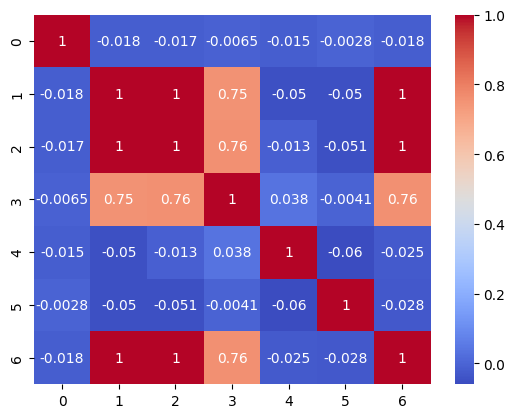

In [ ]:
# examine relationships among five selected features, along with LogReturn and CloseLag1
XStudy = btc.select('LogReturn','CloseLag1','CloseLag3','HMLLag1','OMCLag2','OMCLag3','CloseEMA8')

# prepare correlation heat map using seaborn
corrMatrix = XStudy.corr()
print(corrMatrix)
sns.heatmap(corrMatrix, cmap='coolwarm', annot=True)
plt.show()

In [ ]:
# select subset of five columns as features
X = btc.select('CloseLag3','HMLLag1','OMCLag2','OMCLag3','CloseEMA8')

### Define Cross-Validation Training and Test Sets
Recognizing that time series observations are not independent observations, we use Scikit-Learn [TimeSeriesSplit](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html) for cross-validation. 

This cross-validation object is a variation of multi-fold cross-validation for independent observations. In the kth split, it returns first k folds as train set and the (k+1)th fold as test set.

Unlike cross-validation for independent observations, however, successive training sets are supersets of those that come before them. A listing of observation index numbers shows what this means for the time series market data in this demonstration.


In [44]:
# Splitting the datasets into train and test sets
# gap is the number of samples to exclude from 
# the end of each train set and before the next test set.
tscv = TimeSeriesSplit(gap=10, n_splits=5)

all_splits = list(tscv.split(X, y))
train_0, test_0 = all_splits[0]
train_1, test_1 = all_splits[1]
train_2, test_2 = all_splits[2]
train_3, test_3 = all_splits[3]
train_4, test_4 = all_splits[4]

# examine the objects created for cross-validation splits
print("type(all_splits):", type(all_splits), " outer list length", len(all_splits))
print()
print("train_0 has",len(train_0),"with indices from ",min(train_0),"to",max(train_0))
print("test_0 has",len(test_0),"with indices from ",min(test_0),"to",max(test_0))
print()
print("train_1 has",len(train_1),"with indices from ",min(train_1),"to",max(train_1))
print("test_1 has",len(test_1),"with indices from ",min(test_1),"to",max(test_1))
print()
print("train_2 has",len(train_2),"with indices from ",min(train_2),"to",max(train_2))
print("test_2 has",len(test_2),"with indices from ",min(test_2),"to",max(test_2))
print()
print("train_3 has",len(train_3),"with indices from ",min(train_3),"to",max(train_3))
print("test_3 has",len(test_3),"with indices from ",min(test_3),"to",max(test_3))
print()
print("train_4 has",len(train_4),"with indices from ",min(train_4),"to",max(train_4))
print("test_4 has",len(test_4),"with indices from ",min(test_4),"to",max(test_4))

# to see all indices we can uncomment these statements
# print("elements of all_splits list of lists,\n shows index numbers for each the five lists")
# print(all_splits)

type(all_splits): <class 'list'>  outer list length 5

train_0 has 643 with indices from  0 to 642
test_0 has 650 with indices from  653 to 1302

train_1 has 1293 with indices from  0 to 1292
test_1 has 650 with indices from  1303 to 1952

train_2 has 1943 with indices from  0 to 1942
test_2 has 650 with indices from  1953 to 2602

train_3 has 2593 with indices from  0 to 2592
test_3 has 650 with indices from  2603 to 3252

train_4 has 3243 with indices from  0 to 3242
test_4 has 650 with indices from  3253 to 3902


### Define an Initial Classification Model to Be Evaluated¶
We again select gradient boosting from the XGBoost package, this time defining a classification model to be evaluated. Hyperparameters are retained at defauld settings, except for n_estimators.

In [45]:
model = XGBClassifier(objective='binary:logistic', n_estimators=1000, random_state=2025)

### Evaluate a Classification Model Within the Time Series Cross-Validation Design
Prior to executing a full-blown search for the "best" classification model, we test the cross-validation design on a binary classification model, revising code provided in online documentation for Scikit-Learn: [Time-related feature engineerng](https://scikit-learn.org/stable/auto_examples/applications/plot_cyclical_feature_engineering.html#sphx-glr-auto-examples-applications-plot-cyclical-feature-engineering-py). In particular, we define appropriate metrics for assessing classification performance.

In [46]:
def evaluate(model, X, y, cv, model_prop=None, model_step=None):
    cv_results = cross_validate(
        model,
        X,
        y,
        cv=cv,
        scoring=["accuracy"],
        return_estimator=model_prop is not None,
    )
    if model_prop is not None:
        if model_step is not None:
            values = [
                getattr(m[model_step], model_prop) for m in cv_results["estimator"]
            ]
        else:
            values = [getattr(m, model_prop) for m in cv_results["estimator"]]
        print(f"Mean model.{model_prop} = {np.mean(values)}")
    accuracy = -cv_results["test_accuracy"]

    # print used in earlier testing
    # print(
    #    f"Mean Accuracy:     {-accuracy.mean():.3f} +/- {accuracy.std():.3f}\n"
    # )
    return (-accuracy.mean(), accuracy.std())
    
evaluate(model, X, y, cv=tscv, model_prop="n_estimators")



Mean model.n_estimators = 1000.0


(0.5021538461538462, 0.028427838676802694)

In [47]:
# print results from evaluate
accuracyMean, accuracyStd = evaluate(model, X, y, cv=tscv, model_prop="n_estimators")
print(
        f"Mean Accuracy:     {accuracyMean:.3f} +/- {accuracyStd:.3f}\n"
     )

Mean model.n_estimators = 1000.0
Mean Accuracy:     0.502 +/- 0.028



### Randomized Search for Hyperparameter Settings
We search for effective values on five XGBoost hyperparameters: **max_depth**, **min_child_weight**, **subsample**, **learning_rate**, and **n_estimators**.

In [48]:
# Randomized search to find the best set of hyperparameters

param_dist = {
    'max_depth': randint(3, 10),
    'min_child_weight': randint(1, 10),
    'subsample': uniform(0.5, 1),
    'learning_rate': uniform(0.01, 0.1),
    'n_estimators': randint(100, 1000),
}
xgb_model = xgb.XGBClassifier(objective='binary:logistic', use_label_encoder=False, eval_metric='logloss', random_state=2025)

random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=100, # Number of parameter settings that are sampled.
    scoring='accuracy',
    cv = TimeSeriesSplit(gap=10, n_splits=5),
    random_state=2025,
    n_jobs=-1 # Use all available cores
)

random_search.fit(X, y)

print("Best parameters:", random_search.best_params_)
print("Best score:", random_search.best_score_)

Best parameters: {'learning_rate': 0.1028257981371853, 'max_depth': 3, 'min_child_weight': 6, 'n_estimators': 110, 'subsample': 0.9926169375062625}
Best score: 0.5178461538461537


### Evaluate the Model
We define define an XGBoost subset model with these hyperparameter values and evaluate on the full data set.

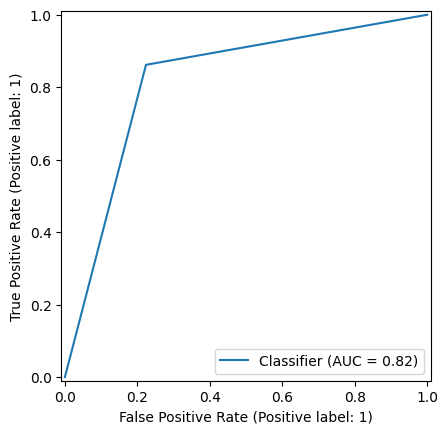

In [49]:
# final model evaluation
finalModel = XGBClassifier(objective='binary:logistic', eval_metric='logloss', random_state=2025,
                          max_depth = 9, min_child_weight = 9, subsample = 0.50, learning_rate = 0.09, n_estimators = 273)

finalModel.fit(X, y)
ypred = finalModel.predict(X)
RocCurveDisplay.from_predictions(y, ypred)
                    

Confusion Matrix
[[1429  412]
 [ 285 1777]]


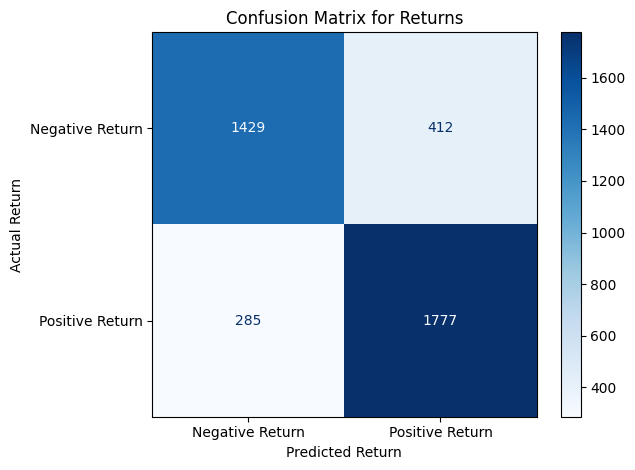

In [50]:
print("Confusion Matrix")
print(confusion_matrix(y, ypred))
disp = ConfusionMatrixDisplay.from_predictions(y, ypred,
                              display_labels =["Negative Return","Positive Return"],
                                              cmap = plt.cm.Blues)
plt.title("Confusion Matrix for Returns")
plt.xlabel("Predicted Return")
plt.ylabel("Actual Return")
plt.tight_layout()
plt.show()                              

In [51]:
print(classification_report(y, ypred, labels = ["0","1"]))

              precision    recall  f1-score   support

           0       0.83      0.78      0.80      1841
           1       0.81      0.86      0.84      2062

   micro avg       0.82      0.82      0.82      3903
   macro avg       0.82      0.82      0.82      3903
weighted avg       0.82      0.82      0.82      3903



## References

* [yfinance GitHub](https://github.com/ranaroussi/yfinance)
* [yfinance Documentation](https://ranaroussi.github.io/yfinance/)
* [Polars Online User Guide](https://docs.pola.rs/)
* [Build Polars Database](https://www.pyquantnews.com/free-python-resources/build-stock-database-locally-with-polars)
* [YouTube. Polars and Time Series: What It Can Do, and How to Overcome Any Limitation](https://www.youtube.com/watch?v=qz-zAHBz6Ks)
* [Awesome Quant: Python for Quantiative Finance](https://wilsonfreitas.github.io/awesome-quant/)
* [Cross-validation](https://scikit-learn.org/stable/modules/cross_validation.html)
* [TimeSeriesSplit](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html)
* [RandomizedSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html)
* [Hyperparameter Tuning](https://scikit-learn.org/stable/modules/grid_search.html#grid-search)
* [Metrics and Scoring](https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter)
* [Introduction to Boosted Trees](https://xgboost.readthedocs.io/en/latest/tutorials/model.html)
* [XGBoost documentation](https://xgboost.readthedocs.io/en/latest/index.html)
* [XGBoost in Python documentation](https://xgboost-clone.readthedocs.io/en/latest/python/python_intro.html)
* [Auto-Sklearn for AutoML in an Scikit-Learn Environment](https://www.automl.org/automl-for-x/tabular-data/auto-sklearn/).